<a href="https://colab.research.google.com/github/quinn-hoang/Coursework-portfolio/blob/main/Stock_market_forecasting_using_time_series_analysis_with_ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.3 MB/s eta 0:00:00


reference: https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/

ARIMA model analyses historical data to predict future stock prices, aiding short term investment decisions
-AR
-Differencing
-Moving Average (MA)

In [3]:
#loading required library
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import  seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
import yfinance as yf

In [5]:
import datetime
start_date =datetime.datetime(2017,1,1)
end_date =datetime.datetime(2024,6,30)

In [6]:
Ticker = ['^GSPC','JPM']

In [7]:
data = yf.download(Ticker,start=start_date,end=end_date)['Close']
data

[*********************100%%**********************]  2 of 2 completed


Ticker,JPM,^GSPC
Date,,
2017-01-03,87.230003,2257.830078
2017-01-04,86.910004,2270.750000
2017-01-05,86.110001,2269.000000
2017-01-06,86.120003,2276.979980
2017-01-09,86.180000,2268.899902
...,...,...
2024-06-24,198.880005,5447.870117
2024-06-25,198.070007,5469.299805
2024-06-26,197.429993,5477.899902


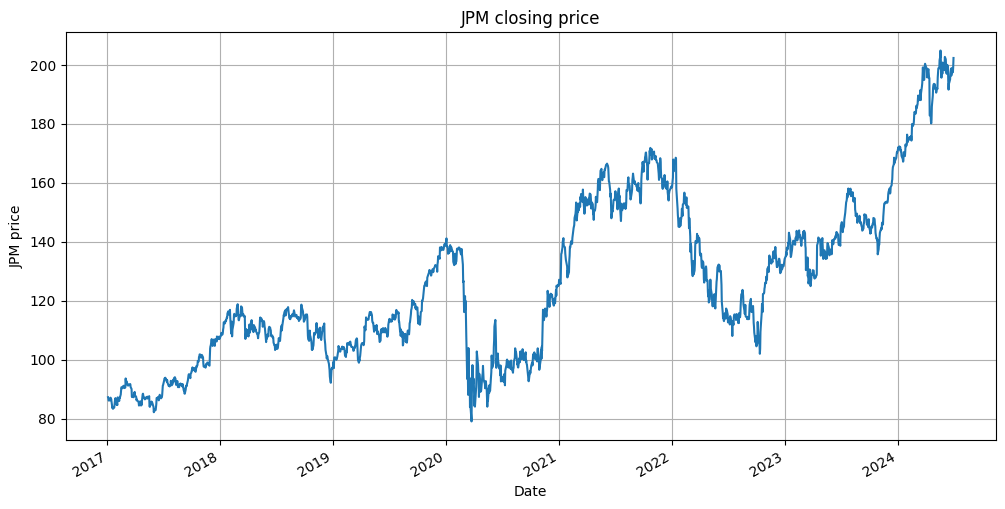

In [8]:
data.JPM.plot(figsize=(12,6),grid='True')
plt.xlabel('Date')
plt.ylabel('JPM price')
plt.title('JPM closing price')
plt.show()

<Axes: ylabel='Density'>

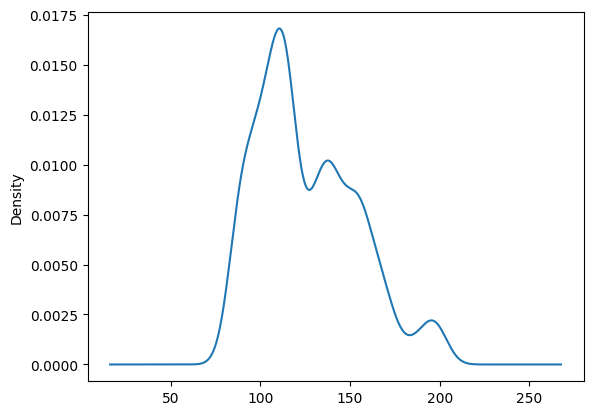

In [9]:
data.JPM.plot(kind='kde')

# TEST FOR STATIONARITY

A time series includes 3 components: level, trend, and seasonality, and non-systematic component: noise
-level: average value
-trend: increasing or falling value in the series
-seasonailily: recurring short-term cycle
- random variance: noise

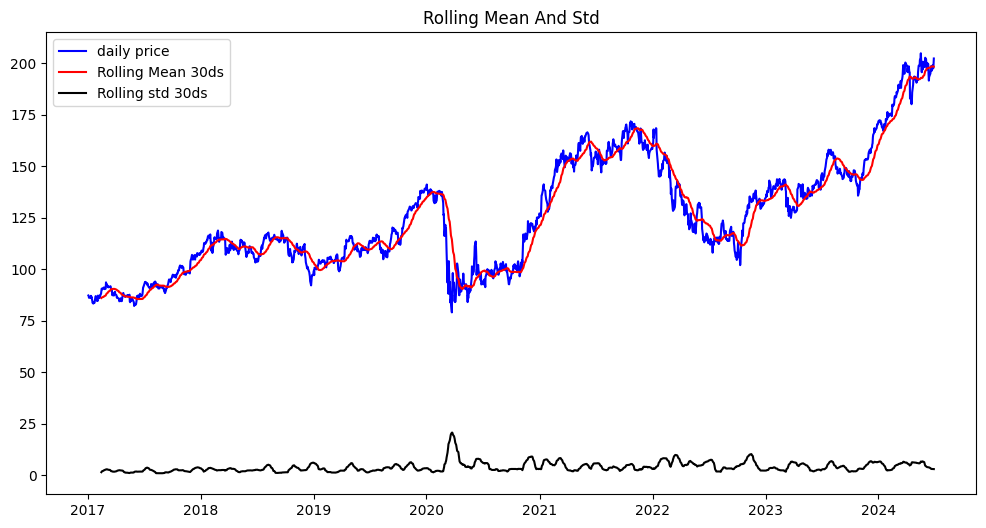

result of dickey fuller test
Test Statistics           -0.671656
p_value                    0.853955
No.of lags used           13.000000
number of obs used      1870.000000
critical value (1%)       -3.433852
critical value (5%)       -2.863087
critical value (10%)      -2.567593
dtype: float64


In [10]:
#test for stationary
def test_stationarity(timeseries):
    #determing rolling statistics
    rollmean=timeseries.rolling(30).mean()
    rollstd =timeseries.rolling(30).std()
    #plot rolling statistics
    plt.figure(figsize=(12,6))
    plt.plot(timeseries,color='blue',label ='daily price')
    plt.plot(rollmean,color='red',label='Rolling Mean 30ds')
    plt.plot(rollstd,color='black',label='Rolling std 30ds')
    plt.legend(loc='best')
    plt.title('Rolling Mean And Std')
    plt.show(block=False)
    print('result of dickey fuller test')
    adft = adfuller(timeseries,autolag='AIC')
    #output for dft will give us without defining what the values are
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p_value','No.of lags used','number of obs used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key]=values
    print(output)

test_stationarity(data.JPM)

If the null hypothesis is not rejected, the series is said to be non-stationary

# Eliminate Trend and Seasonality

seasonality and trend may need to be separated from our series before we can undertake a time series analysis

<Figure size 640x480 with 0 Axes>

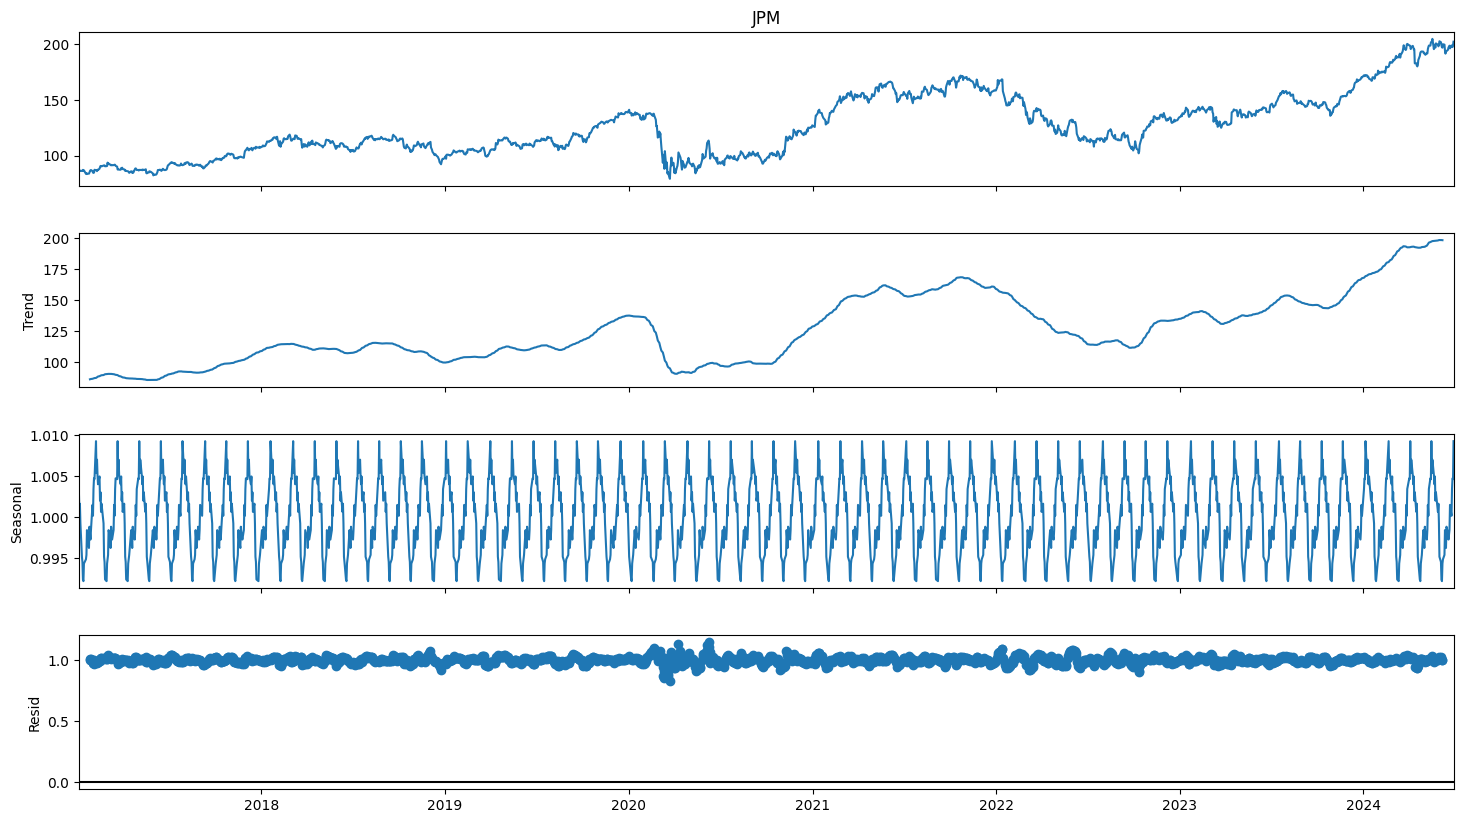

In [11]:
#decompose the series'trend and seasonality
result =seasonal_decompose(data.JPM,model='multiplicative',period=30)
fig =plt.figure()
fig=result.plot()
fig.set_size_inches(16,9)

to reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. then, calculating the rolling average of the series after obtaining the log of the series. a rolling average is computed by taking data from previous 30days and calculating a mean cinsumption value at each subsequent point in the series

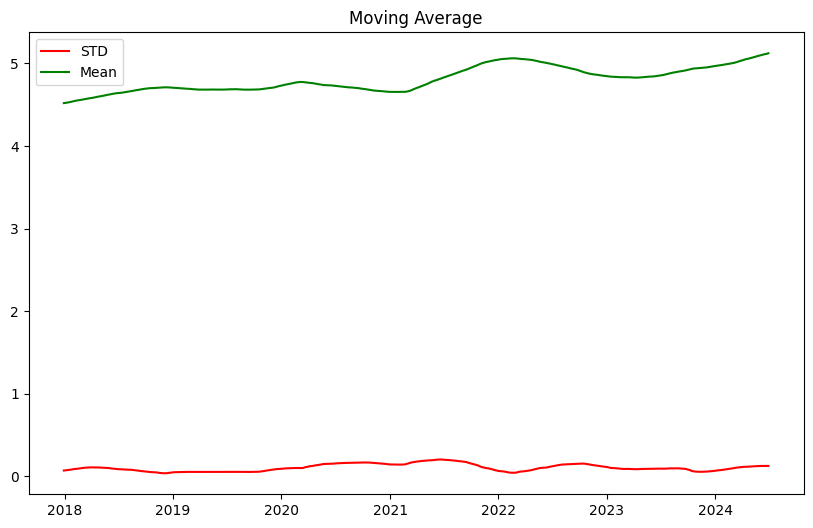

In [12]:
#eliminate trend
from pylab import rcParams
rcParams['figure.figsize']=10,6
df_log =np.log(data.JPM)
moving_avg=df_log.rolling(251).mean()
std_dev=df_log.rolling(251).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev,color='red',label='STD')
plt.plot(moving_avg,color='green',label='Mean')
plt.legend()
plt.show()

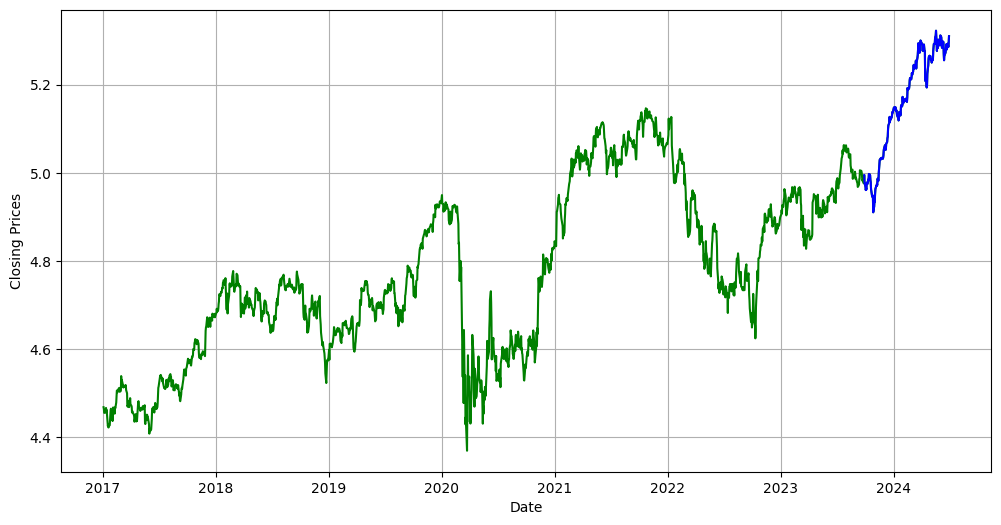

In [13]:
#split the data into train and test sets
train_df,test_df = df_log[3:int(len(df_log)*0.9)],df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.plot(df_log,'green',label='Train data')
plt.plot(test_df,'blue',label='Test data')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8700.048, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8723.456, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8719.319, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8701.567, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8736.211, Time=0.78 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-8734.323, Time=0.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8734.088, Time=0.90 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8729.842, Time=1.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-8732.449, Time=1.82 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-8737.703, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8724.843, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-8735.807, Time=0.82 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8735.584, Time=0.93 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8725.564, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0

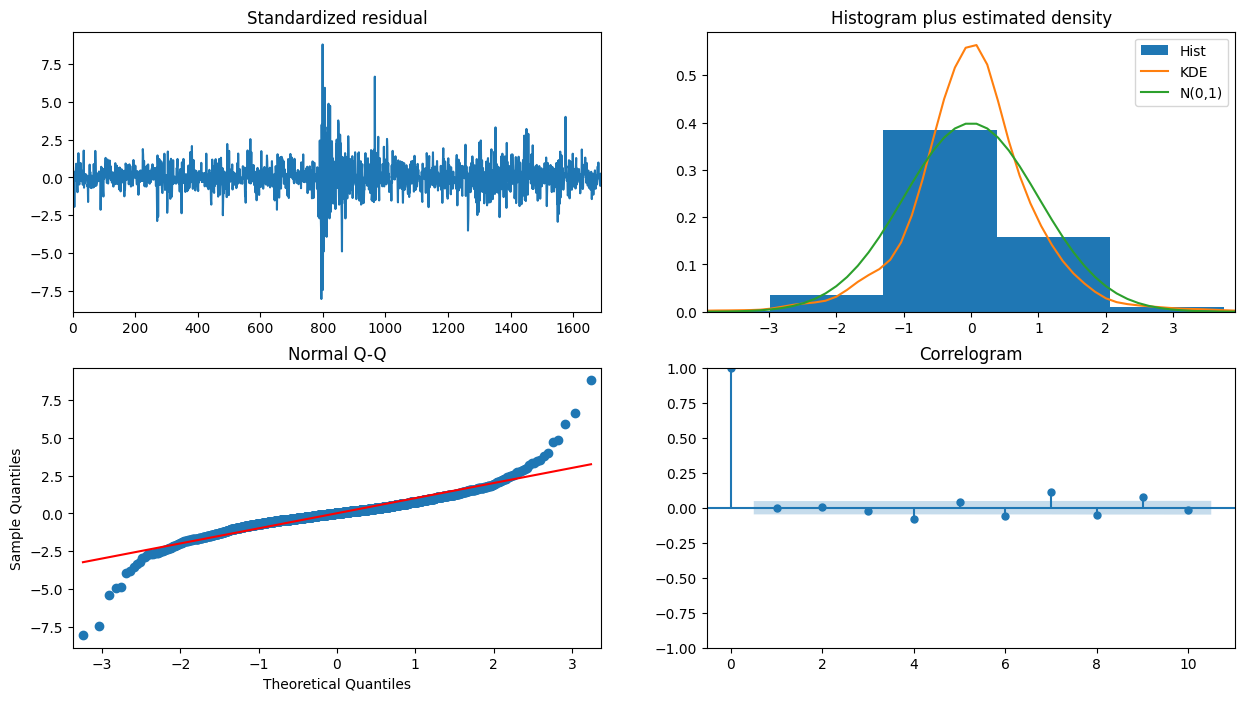

In [14]:
model_autoARIMA = auto_arima(train_df,start_p=0,start_q=0,
                            test = 'adf', #use adftest to find optial 'd'
                            max_p=3,max_q=3,
                            m=1,#frequency of series
                            d=None, #let model determine 'd'
                            seasonal=False, #No seasonality
                            start_P=0,
                            D=0,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [22]:
#the best model is 2,1,0
import statsmodels.api as sm
model =sm.tsa.ARIMA(train_df,order=(2,1,0))
fitted=model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                    JPM   No. Observations:                 1692
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4371.851
Date:                Tue, 09 Jul 2024   AIC                          -8737.703
Time:                        07:48:31   BIC                          -8721.404
Sample:                             0   HQIC                         -8731.667
                               - 1692                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1105      0.010    -11.045      0.000      -0.130      -0.091
ar.L2          0.0936      0.011      8.211      0.000       0.071       0.116
sigma2         0.0003   4.67e-06     71.155      0.0

# Modeling and Forecasting

In [26]:
# Forecast
forecast_steps = len(test_df)

forecast_obj = fitted.get_forecast(forecast_steps, alpha=0.05)  # 95% conf

# Get the forecasted values
fc_series = forecast_obj.predicted_mean

# Get the standard errors
se_series = forecast_obj.se_mean

# Get the confidence intervals
conf= forecast_obj.conf_int(alpha=0.05)


# Print the results
print("Forecasted values:")
print(fc_series)

print("\nStandard errors:")
print(se_series)

print("\nConfidence intervals:")
print(conf_int)

# # Make as pandas series
fc_series = pd.Series(fc_series, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)
# # Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('JPM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('JPM Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasted values:
1692    4.980476
1693    4.981203
1694    4.980971
1695    4.981064
1696    4.981032
          ...   
1876    4.981041
1877    4.981041
1878    4.981041
1879    4.981041
1880    4.981041
Name: predicted_mean, Length: 189, dtype: float64

Standard errors:
1692    0.018232
1693    0.024401
1694    0.030410
1695    0.035209
1696    0.039529
          ...   
1876    0.243777
1877    0.244436
1878    0.245093
1879    0.245748
1880    0.246401
Name: var_pred_mean, Length: 189, dtype: float64

Confidence intervals:
      lower JPM  upper JPM
1692   4.944742   5.016210
1693   4.933377   5.029028
1694   4.921369   5.040572
1695   4.912057   5.050072
1696   4.903556   5.058509
...         ...        ...
1876   4.503246   5.458836
1877   4.501956   5.460127
1878   4.500669   5.461414
1879   4.499385   5.462698
1880   4.498105   5.463978

[189 rows x 2 columns]


InvalidIndexError: (slice(None, None, None), 0)

Forecasted values:
1692    4.980476
1693    4.981203
1694    4.980971
1695    4.981064
1696    4.981032
          ...   
1876    4.981041
1877    4.981041
1878    4.981041
1879    4.981041
1880    4.981041
Name: predicted_mean, Length: 189, dtype: float64

Standard errors:
1692    0.018232
1693    0.024401
1694    0.030410
1695    0.035209
1696    0.039529
          ...   
1876    0.243777
1877    0.244436
1878    0.245093
1879    0.245748
1880    0.246401
Name: var_pred_mean, Length: 189, dtype: float64

Confidence intervals:
      lower JPM  upper JPM
1692   4.944742   5.016210
1693   4.933377   5.029028
1694   4.921369   5.040572
1695   4.912057   5.050072
1696   4.903556   5.058509
...         ...        ...
1876   4.503246   5.458836
1877   4.501956   5.460127
1878   4.500669   5.461414
1879   4.499385   5.462698
1880   4.498105   5.463978

[189 rows x 2 columns]


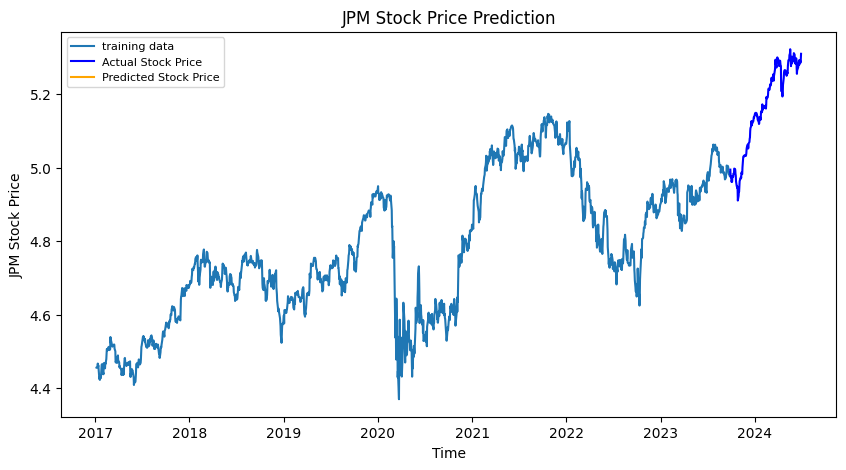

In [27]:
# Forecast
forecast_steps = len(test_df)

forecast_obj = fitted.get_forecast(forecast_steps, alpha=0.05)  # 95% conf

# Get the forecasted values
fc_series = forecast_obj.predicted_mean

# Get the standard errors
se_series = forecast_obj.se_mean

# Get the confidence intervals
conf= forecast_obj.conf_int(alpha=0.05)


# Print the results
print("Forecasted values:")
print(fc_series)

print("\nStandard errors:")
print(se_series)

print("\nConfidence intervals:")
print(conf) # Print the confidence interval DataFrame

# # Make as pandas series
fc_series = pd.Series(fc_series, index=test_df.index)
lower_series = pd.Series(conf['lower JPM'], index=test_df.index) # Extract lower bound from 'lower JPM' column
upper_series = pd.Series(conf['upper JPM'], index=test_df.index) # Extract upper bound from 'upper JPM' column
# # Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_df, label='training data') # Use the correct variable name for training data
plt.plot(test_df, color = 'blue', label='Actual Stock Price') # Use the correct variable name for test data
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('JPM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('JPM Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()